In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter

In [ ]:
def generate_time (t_initial, t_final, n_timesteps):
    t_numpy = np.linspace(t_initial, t_final, n_timesteps)
    t_reshape = t_numpy.reshape(1, -1)
    t_torch = torch.tensor(t_reshape, dtype=torch.float32).to(device)
    return t_numpy, t_reshape, t_torch

def smooth_peak(curve, window_length=11, polyorder=3, baseline_ratio=0.01):
    curve = np.asarray(curve)
    smoothed = savgol_filter(curve, window_length=window_length, polyorder=polyorder)

    peak_idx = np.argmax(smoothed)
    peak_val = smoothed[peak_idx]
    threshold = peak_val * baseline_ratio

    # Find start (left of peak)
    start_idx = 0
    for i in range(peak_idx, 0, -1):
        if smoothed[i] < threshold:
            start_idx = i
            break

    # Find end (right of peak)
    end_idx = len(curve) - 1
    for i in range(peak_idx, len(curve)):
        if smoothed[i] < threshold:
            end_idx = i
            break

    # Keep only the main peak region
    cleaned = np.zeros_like(curve)
    cleaned[start_idx:end_idx + 1] = curve[start_idx:end_idx + 1]

    return cleaned


def zscore(x, eps=1e-12):
    x = np.asarray(x, dtype=float)
    mu = x.mean()
    sd = x.std()
    if sd < eps:
        return x * 0.0
    return (x - mu) / sd

def best_lag_correlation(a, b, max_lag=None, normalize='zscore'):

    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    T = min(len(a), len(b))
    a = a[:T]
    b = b[:T]

    if normalize == 'zscore':
        a_n = zscore(a)
        b_n = zscore(b)
    else:
        a_n = a
        b_n = b

    if max_lag is None:
        max_lag = T - 1

    best_corr = -np.inf
    best_lag = 0
    best_pair = (None, None)

    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            a_slice = a_n[-lag:]
            b_slice = b_n[:T+lag]
        elif lag > 0:

            a_slice = a_n[:T-lag]
            b_slice = b_n[lag:]
        else:
            a_slice = a_n
            b_slice = b_n

        if len(a_slice) < 2:
            continue

        corr = np.dot(a_slice, b_slice) / (len(a_slice) - 1)

        if corr > best_corr:
            best_corr = corr
            best_lag = lag

            if lag < 0:
                a_raw = a[-lag:]
                b_raw = b[:T+lag]
            elif lag > 0:
                a_raw = a[:T-lag]
                b_raw = b[lag:]
            else:
                a_raw = a
                b_raw = b
            best_pair = (a_raw, b_raw)

    return {'lag': best_lag, 'corr': best_corr, 'a_seg': best_pair[0], 'b_seg': best_pair[1]}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(42)

# Input generation

In [ ]:
file_path_up ='/content/drive/MyDrive/Multilayer Perceptron/Data/Static_features.csv' # Update to your local path
df_parameters = pd.read_csv(file_path_up)
data = df_parameters.to_numpy()

In [ ]:
n_timesteps = 100000
t_numpy, t_reshape, t_torch = generate_time(1, 3e6, n_timesteps)
M = np.array(data[:,0]).reshape(-1,1)
W = np.array(data[:,1]).reshape(-1,1)
H = np.array(data[:,2]).reshape(-1,1)
A = np.array(data[:,3]).reshape(-1,1)
u = np.array(data[:,4]).reshape(-1,1)
x = np.array(data[:,5]).reshape(-1,1)
x_upstream = np.array(x/10).reshape(-1,1)
Q = np.array(data[:,6]).reshape(-1,1)
R = 1
theta = 1
D=1

In [ ]:
# Calculate concentration using ADE analytical solution
c_upstream = (1e6 * M) / (2 * theta * A * R * np.sqrt(np.pi * D * t_reshape/ R)) * np.exp(-((x_upstream - u * t_reshape / R) ** 2) / (4 * D * t_reshape / R))

# Target generation

In [ ]:
file_path ='/content/drive/MyDrive/Multilayer Perceptron/Data/Experiemental_BTCs.csv' # Update to your local path
df = pd.read_csv(file_path)
df_numeric = df.apply(pd.to_numeric, errors='coerce')
data = df_numeric.to_numpy()
corrected_data = data.copy()
columns = df.columns

## Data cleaning

In [ ]:
for i in range(0, data.shape[1], 2):
    if i + 1 >= data.shape[1]:
        break  # Ensure we have a pair of columns
    time_col = data[:, i]
    conc_col = data[:, i + 1]

    # Ignore nan values
    valid_indices = ~np.isnan(conc_col)
    time_values = time_col[valid_indices]
    conc_values = conc_col[valid_indices]

    if len(conc_values) == 0:
        continue

    peak_idx = np.argmax(conc_values)

    # Ensure increasing values before the peak. Iterate until we find the next valid value to interpolate (In case there is more than one decreasing value).
    while True:
        fixed = False
        for j in range(1, peak_idx):
            if conc_values[j] < conc_values[j - 1]:  # Not increasing (worng behavior)
                next_valid_idx = j + 1
                while next_valid_idx <= peak_idx and conc_values[next_valid_idx] < conc_values[j - 1]:
                    next_valid_idx += 1

                if next_valid_idx <= peak_idx:
                    conc_values[j:next_valid_idx] = np.linspace(conc_values[j - 1], conc_values[next_valid_idx], (next_valid_idx-j if next_valid_idx-j > 1 else 1))
                    fixed = True
        if not fixed:
            break  # Stop if no more corrections are needed

    # Ensure decreasing values before the peak. Iterate until we find the next valid value to interpolate (In case there is more than one increaing value).
    while True:
        fixed = False
        for j in range(peak_idx + 1, len(conc_values) - 1):
            if conc_values[j] > conc_values[j - 1]:  # Not decreasing (wrong behavior)
                next_valid_idx = j + 1
                while next_valid_idx < len(conc_values) and conc_values[next_valid_idx] > conc_values[j - 1]:
                    next_valid_idx += 1

                if next_valid_idx < len(conc_values):
                    conc_values[j:next_valid_idx] = np.linspace(conc_values[j - 1], conc_values[next_valid_idx], (next_valid_idx-j if next_valid_idx-j > 1 else 1))
                    fixed = True
        if not fixed:
            break  # Stop if no more corrections are needed

    corrected_data[valid_indices, i + 1] = conc_values

In [ ]:
experiment_names = columns[::2]
df_corrected_data = pd.DataFrame(corrected_data, columns=columns)

## Interpolation

In [ ]:
# Define delta time in seconds
t_numpy_exp, t_reshape_exp, t_torch_exp = generate_time(1, 3e6, n_timesteps)
common_time = t_numpy_exp/3600

# Interpolate all experiments Into the common time axis
interpolated_conc_corrected = np.zeros((len(common_time), len(experiment_names)))
for i in range(len(experiment_names)):
    time_col = experiment_names[i]
    conc_col = columns[i * 2 + 1]
    experiment_df = df_corrected_data[[time_col, conc_col]].dropna()
    if experiment_df.empty:
        continue
    time_values = experiment_df[time_col].values
    conc_values = experiment_df[conc_col].values

    # Define the interpolation function
    f_interp = interp1d(time_values, conc_values, kind='linear', bounds_error=False, fill_value=0)

    # Interpolate concentrations into the common time
    interpolated_conc_corrected[:, i] = f_interp(common_time)

In [ ]:
c_dowstream = interpolated_conc_corrected.T
c_upstream = c_upstream
dtype = torch.float32
input = torch.tensor(c_upstream).to(device,dtype)
target = torch.tensor(c_dowstream).to(device,dtype)
dataset = TensorDataset(input, target)
test_indices = [0,5,14,32,34,49,71,83,95,98,106,45,79]
all_indices = np.arange(len(dataset))
train_indices = list(set(all_indices) - set(test_indices))
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

'dataset = TensorDataset(input, target)\ntotal_size = len(dataset)\ntrain_size = int(1 * total_size)\nval_size = int(0* total_size)\ntest_size = total_size - train_size - val_size\nbatch_size = 32\ntrain_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)\ntest_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)'

# Transfer Learning

In [ ]:
input_size = input.shape[1]
output_size = target.shape[1]

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/MACHINE LEARNING PROJECT/SYNTHETIC MLP/model_checkpoint_pretrained.pth", map_location='cpu') # Update to your local path

In [ ]:
model = MLP(input_size, output_size).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

MLP(
  (model): Sequential(
    (0): Linear(in_features=100000, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=100000, bias=True)
  )
)

In [ ]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
# Unfreeze the last layer
for param in model.model[4].parameters():
    param.requires_grad = True
# Optimize only the head
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(50):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[Head only] Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.6f}")

[Head only] Epoch 1, Loss: 405.525959
[Head only] Epoch 2, Loss: 437.607761
[Head only] Epoch 3, Loss: 465.536591
[Head only] Epoch 4, Loss: 589.524582
[Head only] Epoch 5, Loss: 307.274300
[Head only] Epoch 6, Loss: 308.283167
[Head only] Epoch 7, Loss: 293.731340
[Head only] Epoch 8, Loss: 266.220040
[Head only] Epoch 9, Loss: 226.616605
[Head only] Epoch 10, Loss: 216.091429
[Head only] Epoch 11, Loss: 220.120552
[Head only] Epoch 12, Loss: 194.063206
[Head only] Epoch 13, Loss: 175.577547
[Head only] Epoch 14, Loss: 235.782298
[Head only] Epoch 15, Loss: 170.401030
[Head only] Epoch 16, Loss: 161.909365
[Head only] Epoch 17, Loss: 141.696048
[Head only] Epoch 18, Loss: 193.962698
[Head only] Epoch 19, Loss: 128.042800
[Head only] Epoch 20, Loss: 119.867404
[Head only] Epoch 21, Loss: 227.197126
[Head only] Epoch 22, Loss: 109.115488
[Head only] Epoch 23, Loss: 199.796928
[Head only] Epoch 24, Loss: 98.884006
[Head only] Epoch 25, Loss: 90.568202
[Head only] Epoch 26, Loss: 87.33893

In [ ]:
# Set model to evaluation mode
model.eval()

# Lists to store actual and predicted values
actual_curves = []
predicted_curves = []

with torch.no_grad():  # Disable gradient calculations
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)  # Get predictions

        # Move data to CPU for plotting
        actual_curves.extend(batch_y.cpu().numpy())
        predicted_curves.extend(outputs.cpu().numpy())

actual_curves = np.array(actual_curves)
predicted_curves = np.array(predicted_curves)
predicted_curves[predicted_curves < 0] = 0

In [ ]:
max_lag = 1000
use_normalize = 'zscore'

cc_results = []
for i in range(actual_curves.shape[0]):
    a = actual_curves[i]
    b = smooth_peak(predicted_curves[i])
    res = best_lag_correlation(a, b, max_lag=max_lag, normalize=use_normalize)
    cc_results.append(res)

cc_mean_corr = np.mean([r['corr'] for r in cc_results])
print(f"[Cross-Correlation] Mean correlation (at best lag): {cc_mean_corr:.4f}")

[-2.835359573364258, -2.476449728012085, 0.47324007749557495, 0.7970179319381714, -0.6776785850524902, -1.7562711238861084, -0.5824285745620728, -0.6800795793533325, 0.31283777952194214, -0.6377764940261841, -0.004237174987792969, -0.6170958280563354, 0.5675291419029236]
Average R² Score: -0.624366
[np.float64(5.039864315144157), np.float64(0.6536737919840077), np.float64(0.7180404477853332), np.float64(0.12345502916042479), np.float64(0.2815978759829114), np.float64(18.289074180367905), np.float64(0.75378622572154), np.float64(0.08992210371583276), np.float64(0.1724924516667627), np.float64(0.12615314941101738), np.float64(3.63400714879023), np.float64(0.12326007870335753), np.float64(0.04264371024775256)]
Average RMSE: 2.311382
[Cross-Correlation] Mean correlation (at best lag): 0.7162
Lags: [ -127 -1000   -91    13   231  1000   279     0   142   275    67  -172
   -47]
Correlations: [ 8.37661100e-01  1.70198222e-01  8.59588763e-01  9.08515243e-01
  9.02095493e-01 -4.21649519e-05  9

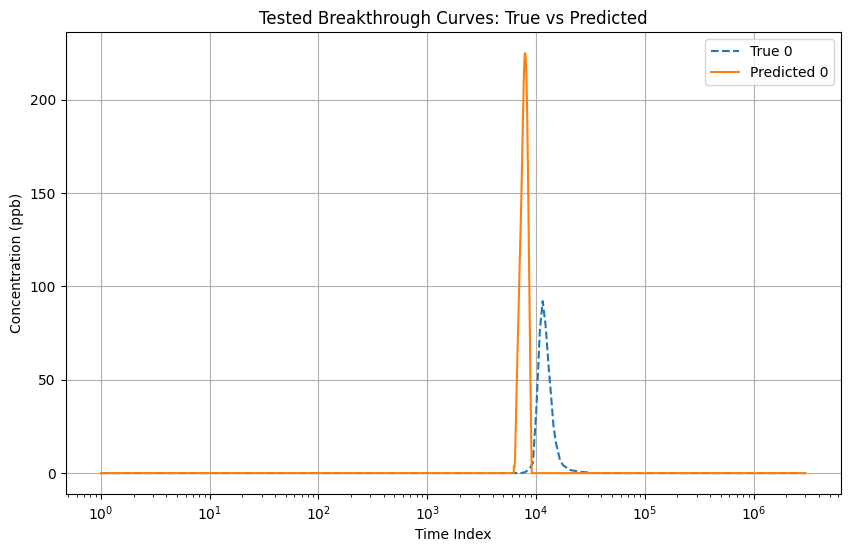

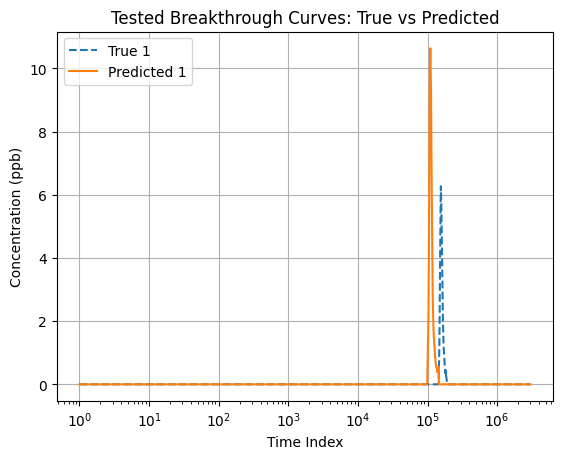

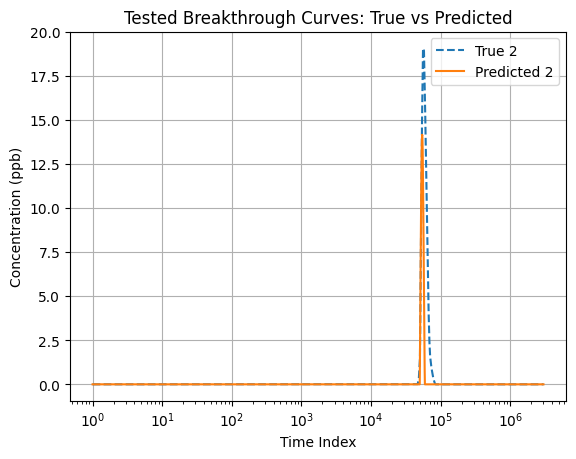

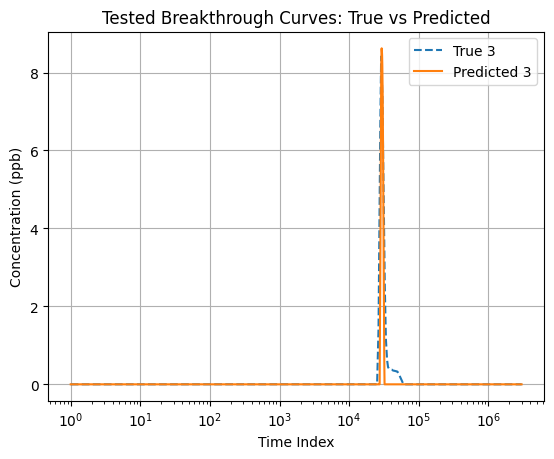

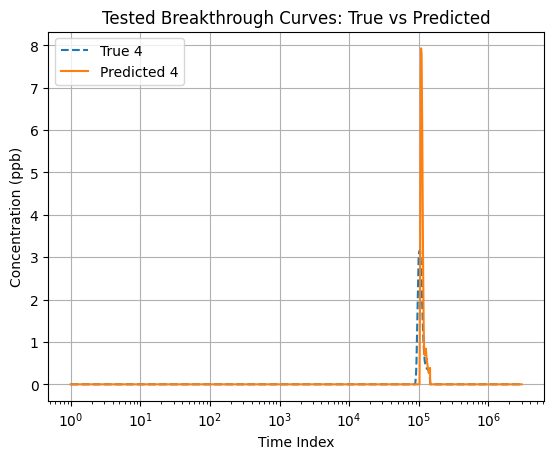

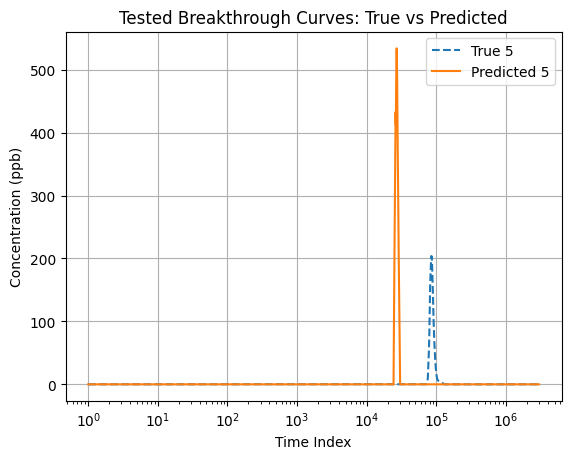

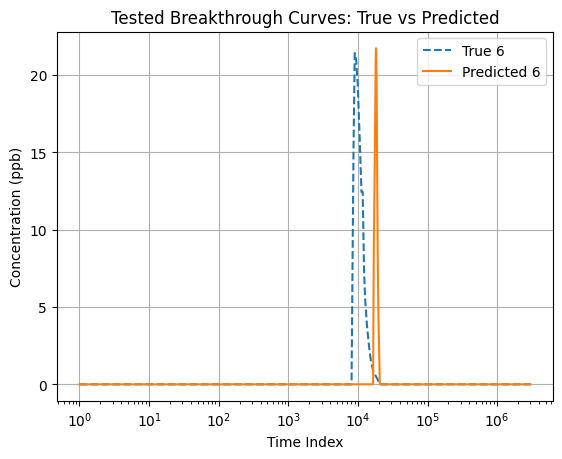

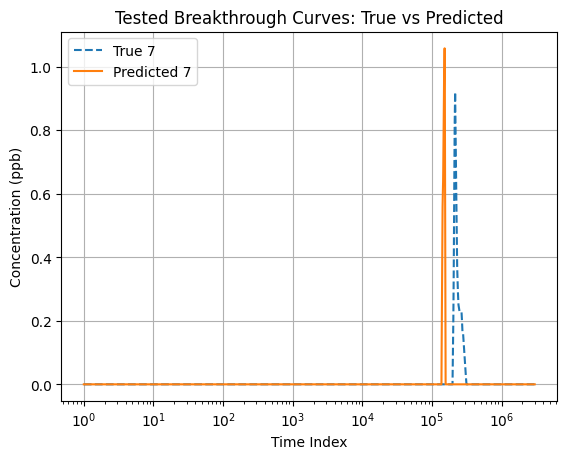

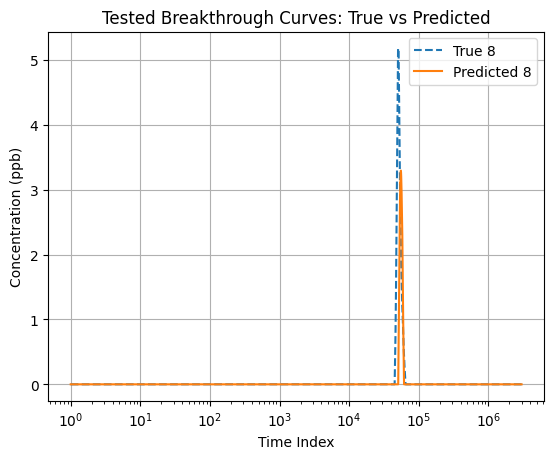

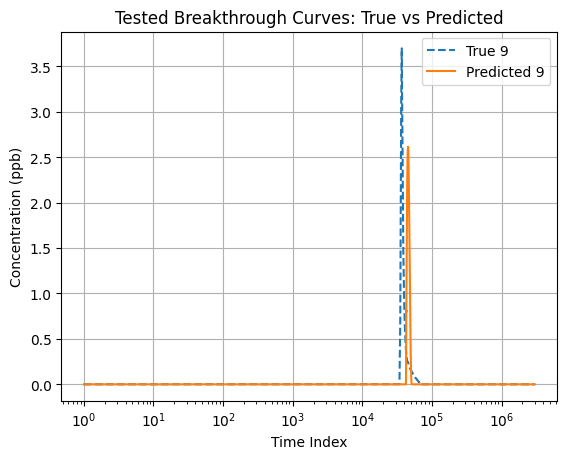

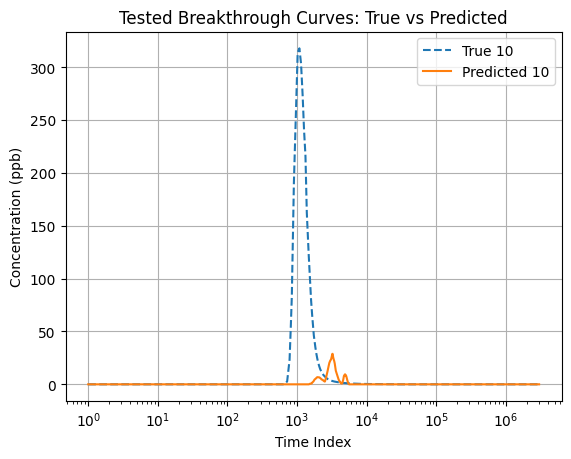

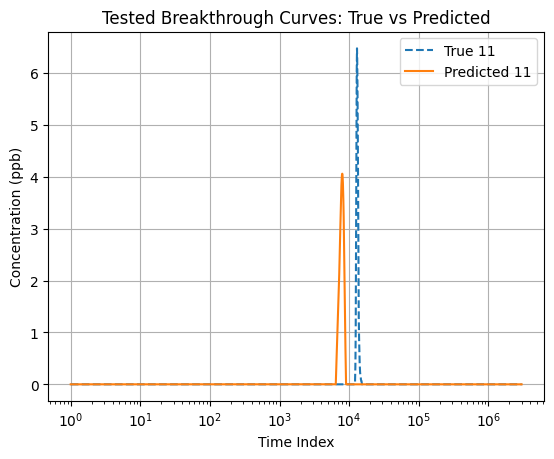

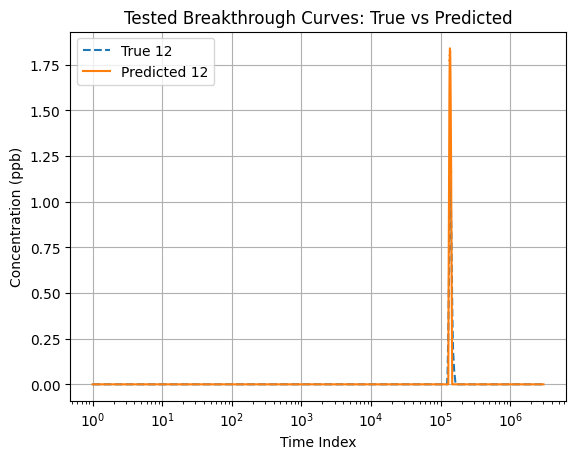

In [ ]:
num_curves_to_plot = len(actual_curves)
plt.figure(figsize=(10, 6))

for i in range(num_curves_to_plot):
    plt.semilogx(t_numpy,actual_curves[i], label=f'True {i}', linestyle='dashed')
    plt.semilogx(t_numpy,smooth_peak(predicted_curves[i]), label=f'Predicted {i}', linestyle='solid')
    plt.grid(True)
    plt.xlabel('Time Index')
    plt.ylabel('Concentration (ppb)')
    plt.title('Tested Breakthrough Curves: True vs Predicted')
    plt.legend()
    plt.show()

R² Score for Peak Concentration: -0.819094
R² Score (normalized independently by max): 0.087134
MAPE (%) respecto a 1:1: 63.923145
Bias Ratio: 1.2523017
Absolute errors: [1.3276180e+02 4.3678498e+00 4.9080696e+00 2.1129799e-01 4.7677002e+00
 3.3009784e+02 3.0510139e-01 1.3762110e-01 1.8855095e+00 1.0859549e+00
 2.8910406e+02 2.4170794e+00 7.2883177e-01]


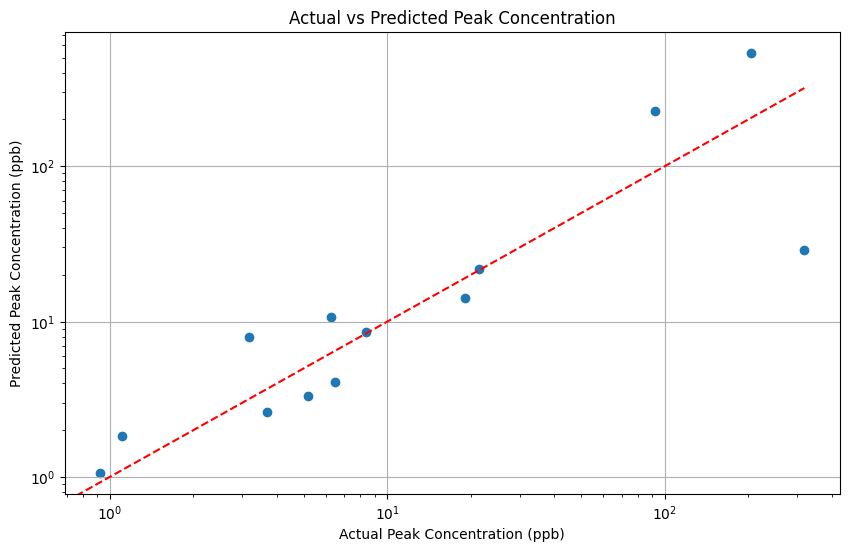

In [ ]:
# Peak concentration
actual_peak = []
predicted_peak = []

# Loop over each curve to get peak value
for i in range(actual_curves.shape[0]):
    actual_peak.append(np.max(actual_curves[i, :]))
    predicted_peak.append(np.max(predicted_curves[i, :]))

# Convert to NumPy arrays
actual_peak = np.array(actual_peak)
predicted_peak = np.array(predicted_peak)

# R2
r2_peak = r2_score(actual_peak, predicted_peak)
print(f'R² Score for Peak Concentration: {r2_peak:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_peak - actual_peak) / actual_peak)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIS RATIO
y_true = actual_peak
y_pred = predicted_peak
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print("Bias Ratio:", bias_ratio)


x1 = np.linspace(0, np.max(actual_peak))
y1=x1
plt.figure(figsize=(10, 6))
plt.scatter(actual_peak,predicted_peak)
plt.xscale('log')
plt.yscale('log')
plt.plot(x1,y1, linestyle='--', color='r')
plt.ylabel('Predicted Peak Concentration (ppb)')
plt.xlabel('Actual Peak Concentration (ppb)')
plt.title('Actual vs Predicted Peak Concentration')
plt.grid(True)
plt.show()

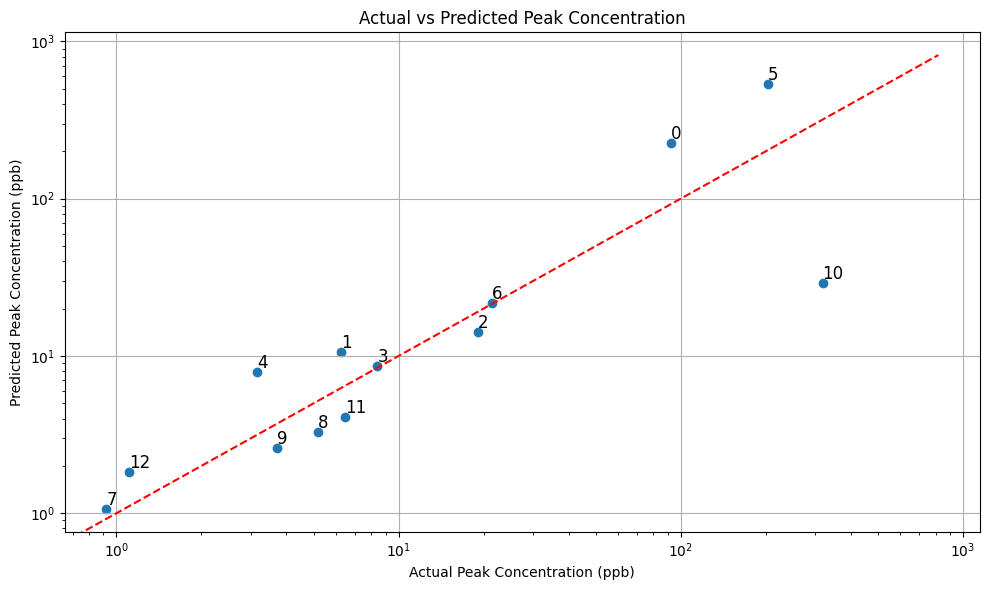

In [ ]:
x1 = np.linspace(0, np.max(actual_peak)+500)
y1 = x1
plt.figure(figsize=(10, 6))
plt.scatter(actual_peak, predicted_peak)
plt.plot(x1, y1, linestyle='--', color='r')
for i, (x, y) in enumerate(zip(actual_peak, predicted_peak)):
    plt.text(x, y, str(i), fontsize=12, ha='left', va='bottom')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted Peak Concentration (ppb)')
plt.xlabel('Actual Peak Concentration (ppb)')
plt.title('Actual vs Predicted Peak Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

R² Score for Peak Time: 0.817245
R² Score (normalized independently by max): 0.810194
MAPE (%) respecto a 1:1: 41.66424471957555
Bias ratio: 0.835
Absolute errors: [ 3570.03451035 45720.44196442  1500.01450015   510.00493005
  4800.04640046 57600.55680557  9180.08874089 63450.61335613
  4950.04785048  8460.08178082  2160.02088021  5010.04843048
  1980.01914019]


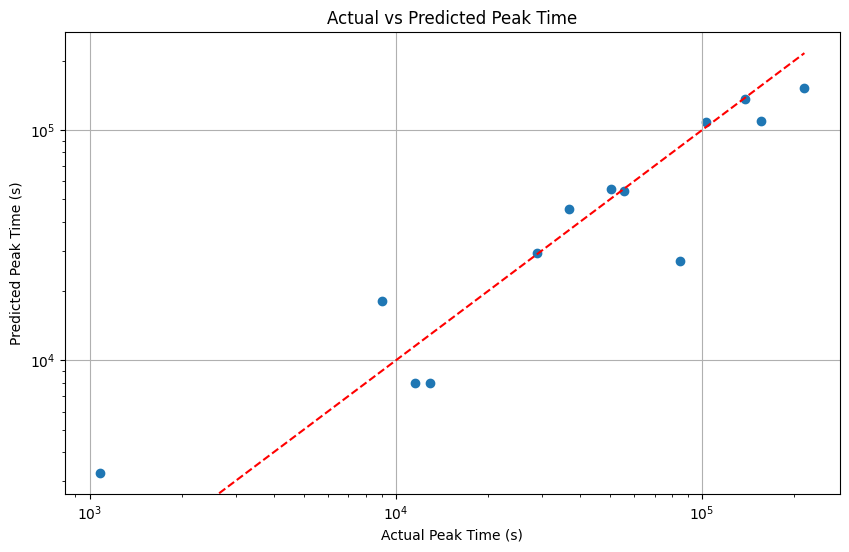

In [ ]:
# Peak time (argmax of each curve)
actual_peaktime = []
predicted_peaktime = []

for i in range(actual_curves.shape[0]):
    actual_peaktime.append(t_numpy[np.argmax(actual_curves[i, :])])
    predicted_peaktime.append(t_numpy[np.argmax(smooth_peak(predicted_curves[i, :]))])

# Convert to arrays
actual_peaktime = np.array(actual_peaktime)
predicted_peaktime = np.array(predicted_peaktime)

# R2
r2_peaktime = r2_score(actual_peaktime, predicted_peaktime)
print(f'R² Score for Peak Time: {r2_peaktime:.6f}')

#MAPE
mape = np.mean(np.abs((predicted_peaktime - actual_peaktime) / actual_peaktime)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_peaktime
y_pred = predicted_peaktime
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x2 = np.linspace(0, np.max(actual_peaktime)+100)
y2=x2
plt.figure(figsize=(10, 6))
plt.scatter(actual_peaktime,predicted_peaktime)
plt.xscale('log')
plt.yscale('log')
plt.plot(x2,y2,linestyle='--', color='r')
plt.ylabel('Predicted Peak Time (s)')
plt.xlabel('Actual Peak Time (s)')
plt.title('Actual vs Predicted Peak Time')
plt.grid(True)
plt.show()

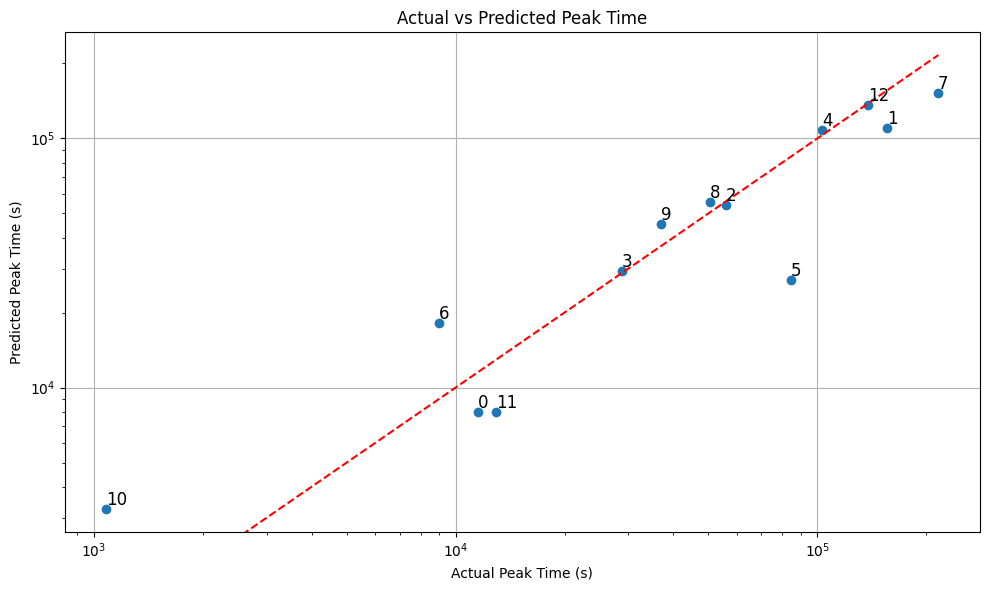

In [ ]:
x2 = np.linspace(0, np.max(actual_peaktime)+500)
y2 = x2
plt.figure(figsize=(10, 6))
plt.scatter(actual_peaktime, predicted_peaktime)
plt.plot(x2, y2, linestyle='--', color='r')
for i, (x, y) in enumerate(zip(actual_peaktime, predicted_peaktime)):
    plt.text(x, y, str(i), fontsize=12, ha='left', va='bottom')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted Peak Time (s)')
plt.xlabel('Actual Peak Time (s)')
plt.title('Actual vs Predicted Peak Time')
plt.grid(True)
plt.tight_layout()
plt.show()

R² Score for M0: 0.836505
R² Score (normalized independently by max): 0.985517
MAPE (%) respecto a 1:1: 38.79172274335947
Bias ratio: 0.654


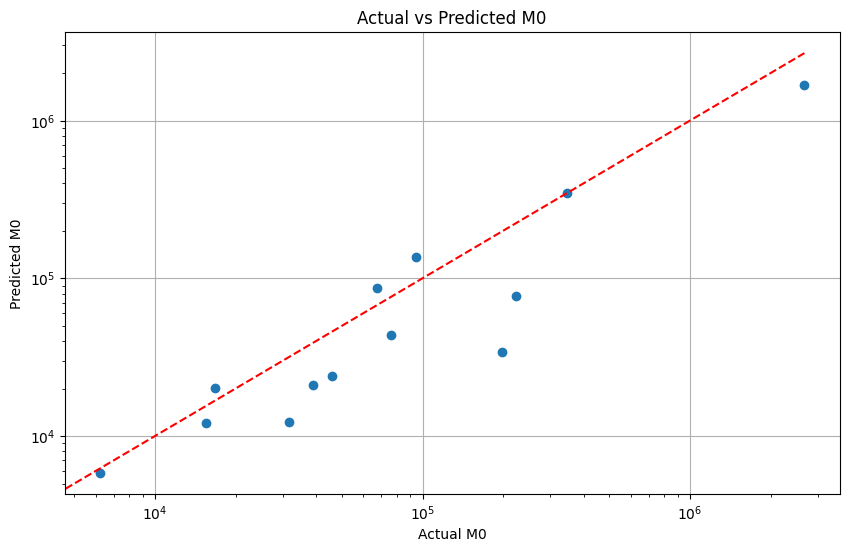

In [ ]:
actual_m0 =[]
predicted_m0 =[]

for i in range(actual_curves.shape[0]):
    actual_m0.append(np.trapezoid(actual_curves[i,:],t_reshape))
    predicted_m0.append(np.trapezoid(smooth_peak(predicted_curves[i,:]),t_reshape))

actual_m0 = np.array(actual_m0)
predicted_m0 = np.array(predicted_m0)

# R2
r2_m0 = r2_score(actual_m0, predicted_m0)
print(f'R² Score for M0: {r2_m0:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_m0 - actual_m0) / actual_m0)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m0
y_pred = predicted_m0
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x3 = np.linspace(0, np.max(actual_m0)+100)
y3=x3
plt.figure(figsize=(10, 6))
plt.scatter(actual_m0,predicted_m0)
plt.xscale('log')
plt.yscale('log')
plt.plot(x3,y3,linestyle='--', color='r')
plt.ylabel('Predicted M0')
plt.xlabel('Actual M0')
plt.title('Actual vs Predicted M0')
plt.grid(True)
plt.show()

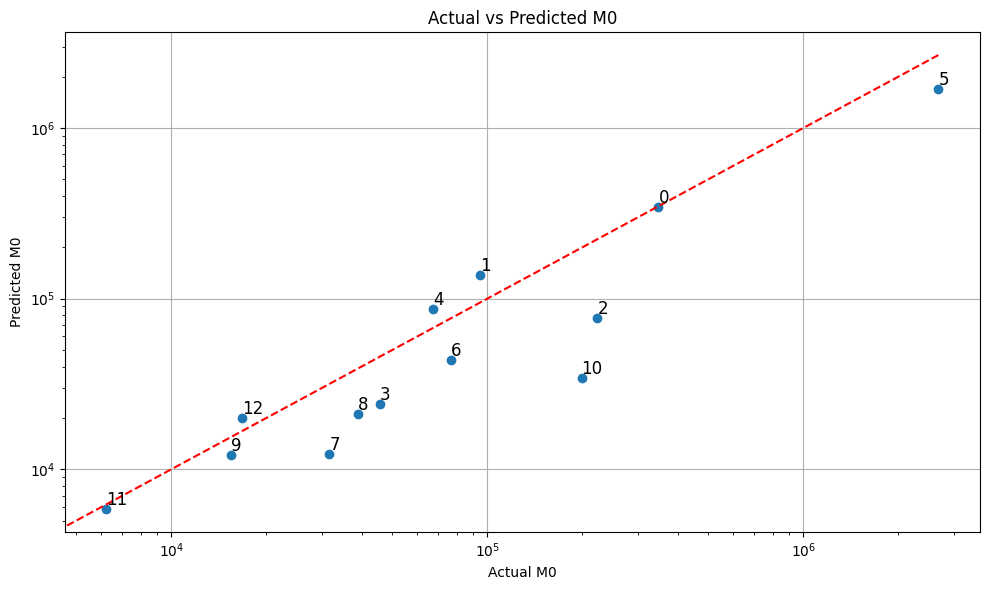

In [ ]:
x3 = np.linspace(0, np.max(actual_m0) + 500)
y3 = x3

plt.figure(figsize=(10, 6))
plt.scatter(actual_m0, predicted_m0)
plt.plot(x3, y3, linestyle='--', color='r')
for i, (x, y) in enumerate(zip(actual_m0, predicted_m0)):
    plt.text(x, y, str(i), fontsize=12, ha='left', va='bottom')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted M0')
plt.xlabel('Actual M0')
plt.title('Actual vs Predicted M0')
plt.grid(True)
plt.show()

R² Score for M1: 0.271557
R² Score (normalized independently by max): 0.870828
MAPE (%) respecto a 1:1: 41.01629880615644
Bias ratio: 0.297


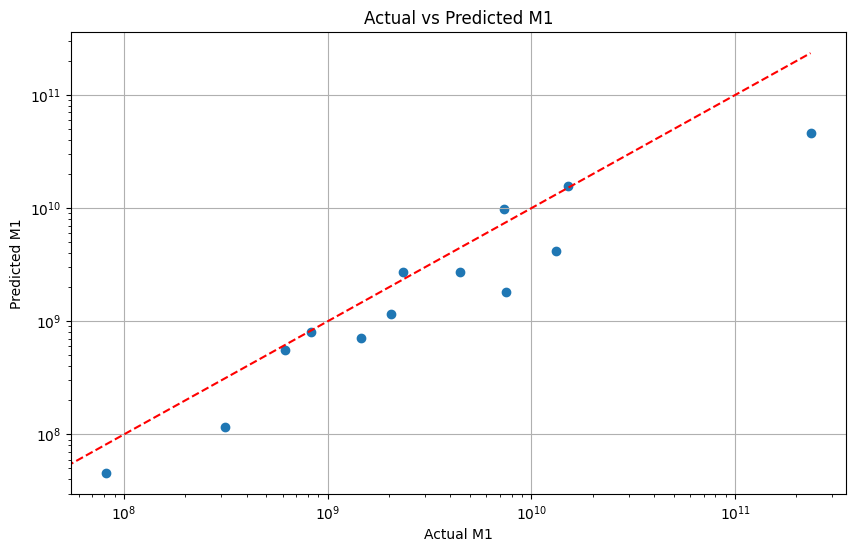

In [ ]:
actual_m1 = []
predicted_m1 = []

for i in range(actual_curves.shape[0]):
    actual_moment = actual_curves[i,:]*t_reshape
    predicted_moment = smooth_peak(predicted_curves[i,:])*t_reshape

    actual_m1.append(np.trapezoid(actual_moment,t_reshape))
    predicted_m1.append(np.trapezoid(predicted_moment,t_reshape))

actual_m1 = np.array(actual_m1)
predicted_m1 = np.array(predicted_m1)

# R2
r2_m1 = r2_score(actual_m1,predicted_m1)
print(f'R² Score for M1: {r2_m1:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_m1 - actual_m1) / actual_m1)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m1
y_pred = predicted_m1
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x4 = np.linspace(0, np.max(actual_m1)+100)
y4=x4
plt.figure(figsize=(10, 6))
plt.scatter(actual_m1,predicted_m1)
plt.plot(x4,y4,linestyle='--', color='r')
plt.ylabel('Predicted M1')
plt.xlabel('Actual M1')
plt.xscale('log')
plt.yscale('log')
plt.title('Actual vs Predicted M1')
plt.grid(True)
plt.show()

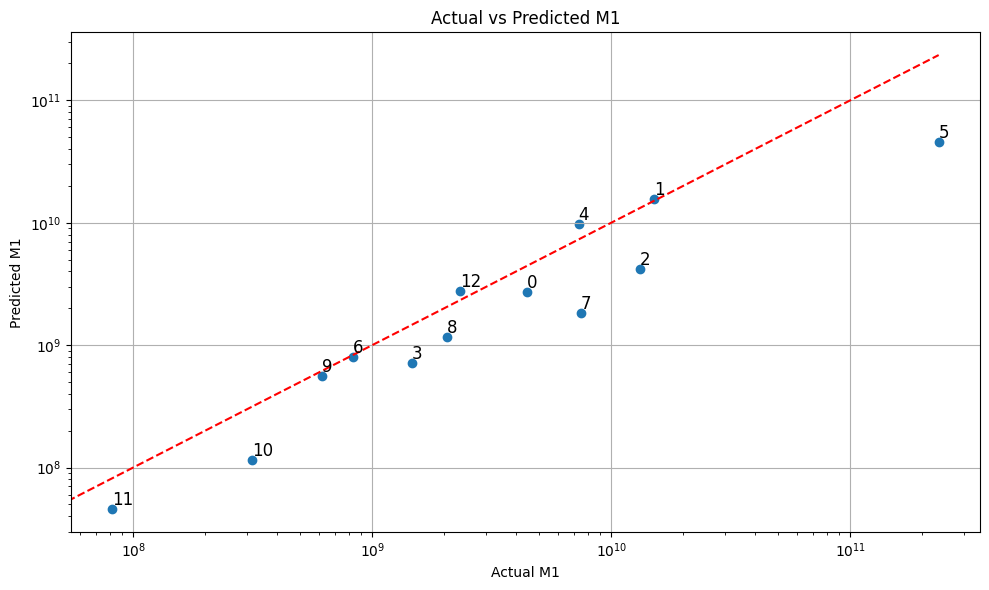

In [ ]:
x4 = np.linspace(0, np.max(actual_m1) + 500)
y4 = x4
plt.figure(figsize=(10, 6))
plt.scatter(actual_m1, predicted_m1)
plt.plot(x4, y4, linestyle='--', color='r')
for i, (x, y) in enumerate(zip(actual_m1, predicted_m1)):
    plt.text(x, y, str(i), fontsize=12, ha='left', va='bottom')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted M1')
plt.xlabel('Actual M1')
plt.title('Actual vs Predicted M1')
plt.grid(True)
plt.tight_layout()
plt.show()